# Q learning - Reinforcement Learning

### Definition

Q-learning is an off policy reinforcement learning algorithm that seeks to find the best action to take given the current state. It’s considered off-policy because the q-learning function learns from actions that are outside the current policy, like taking random actions, and therefore a policy isn’t needed. More specifically, q-learning seeks to learn a policy that maximizes the total reward.

### Goal

The goal of this notebook is to showcase the use of Q-learning in order to buy and sell in order to maximize the money/btc amount.

This is an controlled environment - **DO NOT USE ON REAL BITCOIN**

**Don't forget to up-vote in order to support me from developing new kernels (notebooks)**

## Retrieve data

In [1]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import os

Load price data

In [2]:
prices = np.loadtxt('../input/binance-bitcoin-futures-price-10s-intervals/prices_btc_Jan_11_2020_to_May_22_2020.txt', dtype=float)

In [3]:
len(prices)

1141281

In [4]:
fig = go.Figure(data=go.Scatter(y=prices[-10000:]))
fig.show()

def saludo():
    print("Hola amigas")
    
saludo()

Hola amigas


## Reinforcement Learning

### Functions to buy, sell and wait

In [5]:
def buy(btc_price, btc, money):
    if(money != 0):
        btc = (1 / btc_price ) * money
        money = 0
    return btc, money


def sell(btc_price, btc, money):
    if(btc != 0):
        money = btc_price * btc
        btc = 0
    return btc, money


def wait(btc_price, btc, money):
    # do nothing
    return btc, money

### Create actions, states tables

In [6]:
np.random.seed(1)

# set of actions that the user could do
actions = { 'buy' : buy, 'sell': sell, 'wait' : wait}

actions_to_nr = { 'buy' : 0, 'sell' : 1, 'wait' : 2 }
nr_to_actions = { k:v for (k,v) in enumerate(actions_to_nr) }

nr_actions = len(actions_to_nr.keys())
nr_states = len(prices)

# q-table = reference table for our agent to select the best action based on the q-value
q_table = np.random.rand(nr_states, nr_actions)

### Functions to get rewards and act upon action

In [7]:
def get_reward(before_btc, btc, before_money, money):
    reward = 0
    if(btc != 0):
        if(before_btc < btc):
            reward = 1
    if(money != 0):
        if(before_money < money):
            reward = 1
            
    return reward

In [8]:
def choose_action(state):
    if np.random.uniform(0, 1) < eps:
        return np.random.randint(0, 2)
    else:
        return np.argmax(q_table[state])

In [9]:
def take_action(state, action):
    return actions[nr_to_actions[action]](prices[state], btc, money)

In [10]:
def act(state, action, theta):
    btc, money = theta
    
    done = False
    new_state = state + 1
    
    before_btc, before_money = btc, money
    btc, money = take_action(state, action)
    theta = btc, money
    
    reward = get_reward(before_btc, btc, before_money, money)
    
    if(new_state == nr_states):
        done = True
    
    return new_state, reward, theta, done

### Training the Q table

In [11]:
reward = 0
btc = 0
money = 100

theta = btc, money

In [12]:
# exploratory
eps = 0.3

n_episodes = 20
min_alpha = 0.02

# learning rate for Q learning
alphas = np.linspace(1.0, min_alpha, n_episodes)

# discount factor, used to balance immediate and future reward
gamma = 1.0

#### Steps for Q-network learning

Here are the 3 basic steps:

- Agent starts in a state=0 takes an action and receives a reward
- Agent selects action by referencing Q-table with highest value (max) OR by random (epsilon, ε)
- Update q-values

In [13]:
rewards = {}

for e in range(n_episodes):
    
    total_reward = 0
    
    state = 0
    done = False
    alpha = alphas[e]
    
    while(done != True):

        action = choose_action(state)
        next_state, reward, theta, done = act(state, action, theta)
        
        total_reward += reward
        
        if(done):
            rewards[e] = total_reward
            print(f"Episode {e + 1}: total reward -> {total_reward}")
            break
        
        q_table[state][action] = q_table[state][action] + alpha * (reward + gamma *  np.max(q_table[next_state]) - q_table[state][action])

        state = next_state

Episode 1: total reward -> 620440
Episode 2: total reward -> 699087
Episode 3: total reward -> 724375
Episode 4: total reward -> 747267
Episode 5: total reward -> 764115
Episode 6: total reward -> 776896
Episode 7: total reward -> 788167
Episode 8: total reward -> 795288
Episode 9: total reward -> 799318
Episode 10: total reward -> 801008
Episode 11: total reward -> 805395
Episode 12: total reward -> 808962
Episode 13: total reward -> 810367
Episode 14: total reward -> 811362
Episode 15: total reward -> 813103
Episode 16: total reward -> 813193
Episode 17: total reward -> 813072
Episode 18: total reward -> 813205
Episode 19: total reward -> 813811
Episode 20: total reward -> 814285


### Learning Analysis

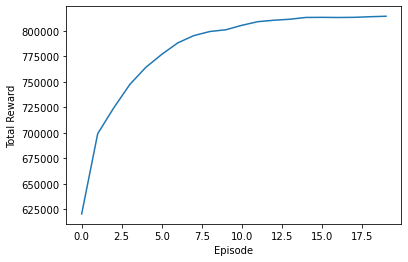

In [14]:
plt.ylabel('Total Reward')
plt.xlabel('Episode')
plt.plot([rewards[e] for e in rewards.keys()])

### Plot the Results

In [15]:
state = 0
acts = np.zeros(nr_states)
done = False

while(done != True):

        action = choose_action(state)
        next_state, reward, theta, done = act(state, action, theta)
        
        acts[state] = action
        
        total_reward += reward
        
        if(done):
            break
            
        state = next_state

In [16]:
buys_idx = np.where(acts == 0)
wait_idx = np.where(acts == 2)
sell_idx = np.where(acts == 1)

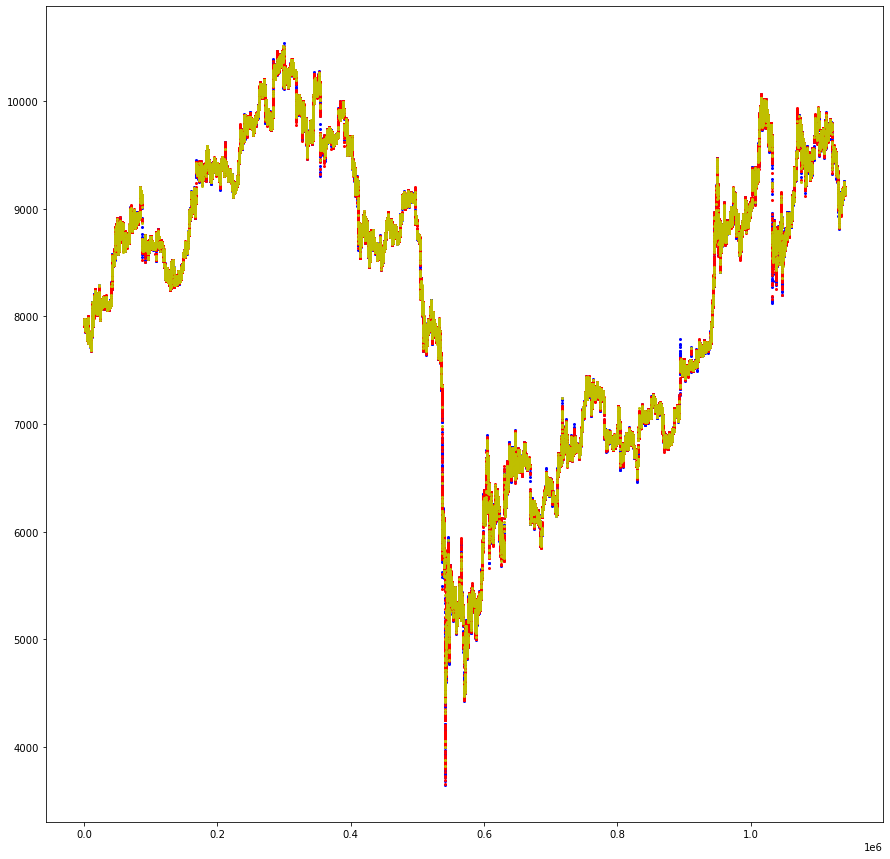

In [17]:
plt.figure(figsize=(15,15))
plt.plot(buys_idx[0], prices[buys_idx], 'bo', markersize=2)
plt.plot(sell_idx[0], prices[sell_idx], 'ro', markersize=2)
plt.plot(wait_idx[0], prices[wait_idx], 'yo', markersize=2)

### Conclusion

Even if we trained for only 20 episodes, we can see clear how the Q learning works in reinforcement learning.<br>
We got a Q network 2D array that holds the best action for each state plus we also use exploratory using (eps) in order to try new actions, if the actions get better rewards, we add them to the Q table by increasing the q table actions using the formula :<br>
> q_table[state][action] + alpha * (reward + gamma *  np.max(q_table[next_state]) - q_table[state][action])